# Plotting a static treemap

--------

This Jupyter notebook will generate a static version of the treemap. In the first step each parent in the JSON gets all of its children's values (read or contig counts) are summed to the parent. In the second step we're assigning a lineage to each treemap compartment to help later. In the last step we produce a copy of the nested treemap structure that's flat for use later.

In [1]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec

typeface='Helvetica Neue'
mpl.rcParams['mathtext.fontset']='custom'
mpl.rcParams['font.sans-serif']=typeface
mpl.rcParams['mathtext.default']='sf'
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

import numpy as np
import json,copy
import ete3
import squarify

ncbi=ete3.ncbi_taxonomy.NCBITaxa()

treemap_path='/Users/evogytis/Documents/manuscripts/skeeters/treemap/skeeters.json'
J=json.load(open(treemap_path,'r'))

def sumValues(node,stat,level=None,order=None):
    '''
    Sum children's values and assign to parent (currently annotations are branch-specific).
    '''
    if level==None:
        level=0
    if order==None:
        order=0
        
    node['attrs']['height']=level ## remember height
    order+=1 ## remember order of visitation
    
    if 'children' in node: ## node with children
        level+=1 ## increment level
        for child in node['children']: ## iterate over children
            if stat not in node['attrs']:
                node['attrs'][stat]=0
            
            order=sumValues(child,stat,level,order) ## traverse first (reaches tips first)
            node['attrs'][stat]+=child['attrs'][stat] ## only then add stat
            
    node['attrs']['order']=order ## assign order of visitation
    return order

def flatten(node,container=None): ## flat list of JSON branches
    """
    Unroll JSON tree structure into a flat list.
    """
    if container==None:
        container=[]
        
    container.append(node)
    if 'children' in node:
        for child in node['children']:
            flatten(child,container)
            
    return container

def treemapLineages(node,lineage=None):
    """
    Assign lineages to each compartment of the treemap.
    """
    if lineage==None:
        lineage=[]
    
    lin=list(lineage)
    
    if 'taxid' in node:
        node['lineage']=lin+[node['taxid']]
    
    if 'children' in node:
        if 'taxid' in node:
            lin.append(node['taxid'])
            
        for child in node['children']:
            lineage=treemapLineages(child,lin)
    
    return lineage

sumValues(J,'read_count') ## sum read counts across children
# sumValues(J,'contig_count')
            
treemapLineages(J) ## assign lineages to each treemap compartment

flatJ=flatten(copy.deepcopy(J)) ## get a flat version of the JSON
print(len(flatJ)) ## report number of branches in JSON treemap
print(flatJ[0]['attrs']['read_count'])

138
12651739


## Plotting treemap

In this cell we define the `size` function which will be used to determine the size of treemap compartments (read counts by default). The parameter `edge_length` by default is computed as the square of the value at the root and passed on as both the `dx` (width) and `dy` (height) of the treemap (_i.e._ treemap is a square).

3556.928309651461


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/squarify/__init__.py:86: RuntimeWarning: divide by zero encountered in double_scalars
  for rect in layout(sizes, x, y, dx, dy)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/squarify/__init__.py:38: RuntimeWarning: invalid value encountered in double_scalars
  height = covered_area / dx
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/squarify/__init__.py:27: RuntimeWarning: invalid value encountered in double_scalars
  rects.append({"x": x, "y": y, "dx": width, "dy": size / width})
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/squarify/__init__.py:28: RuntimeWarning: invalid value encountered in double_scalars
  y += size / width
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/squarify/__init__.py:24: RuntimeWarning: invalid value encountered in double_scalars
  width = covered_area / dy

100.0 3556.928309651461


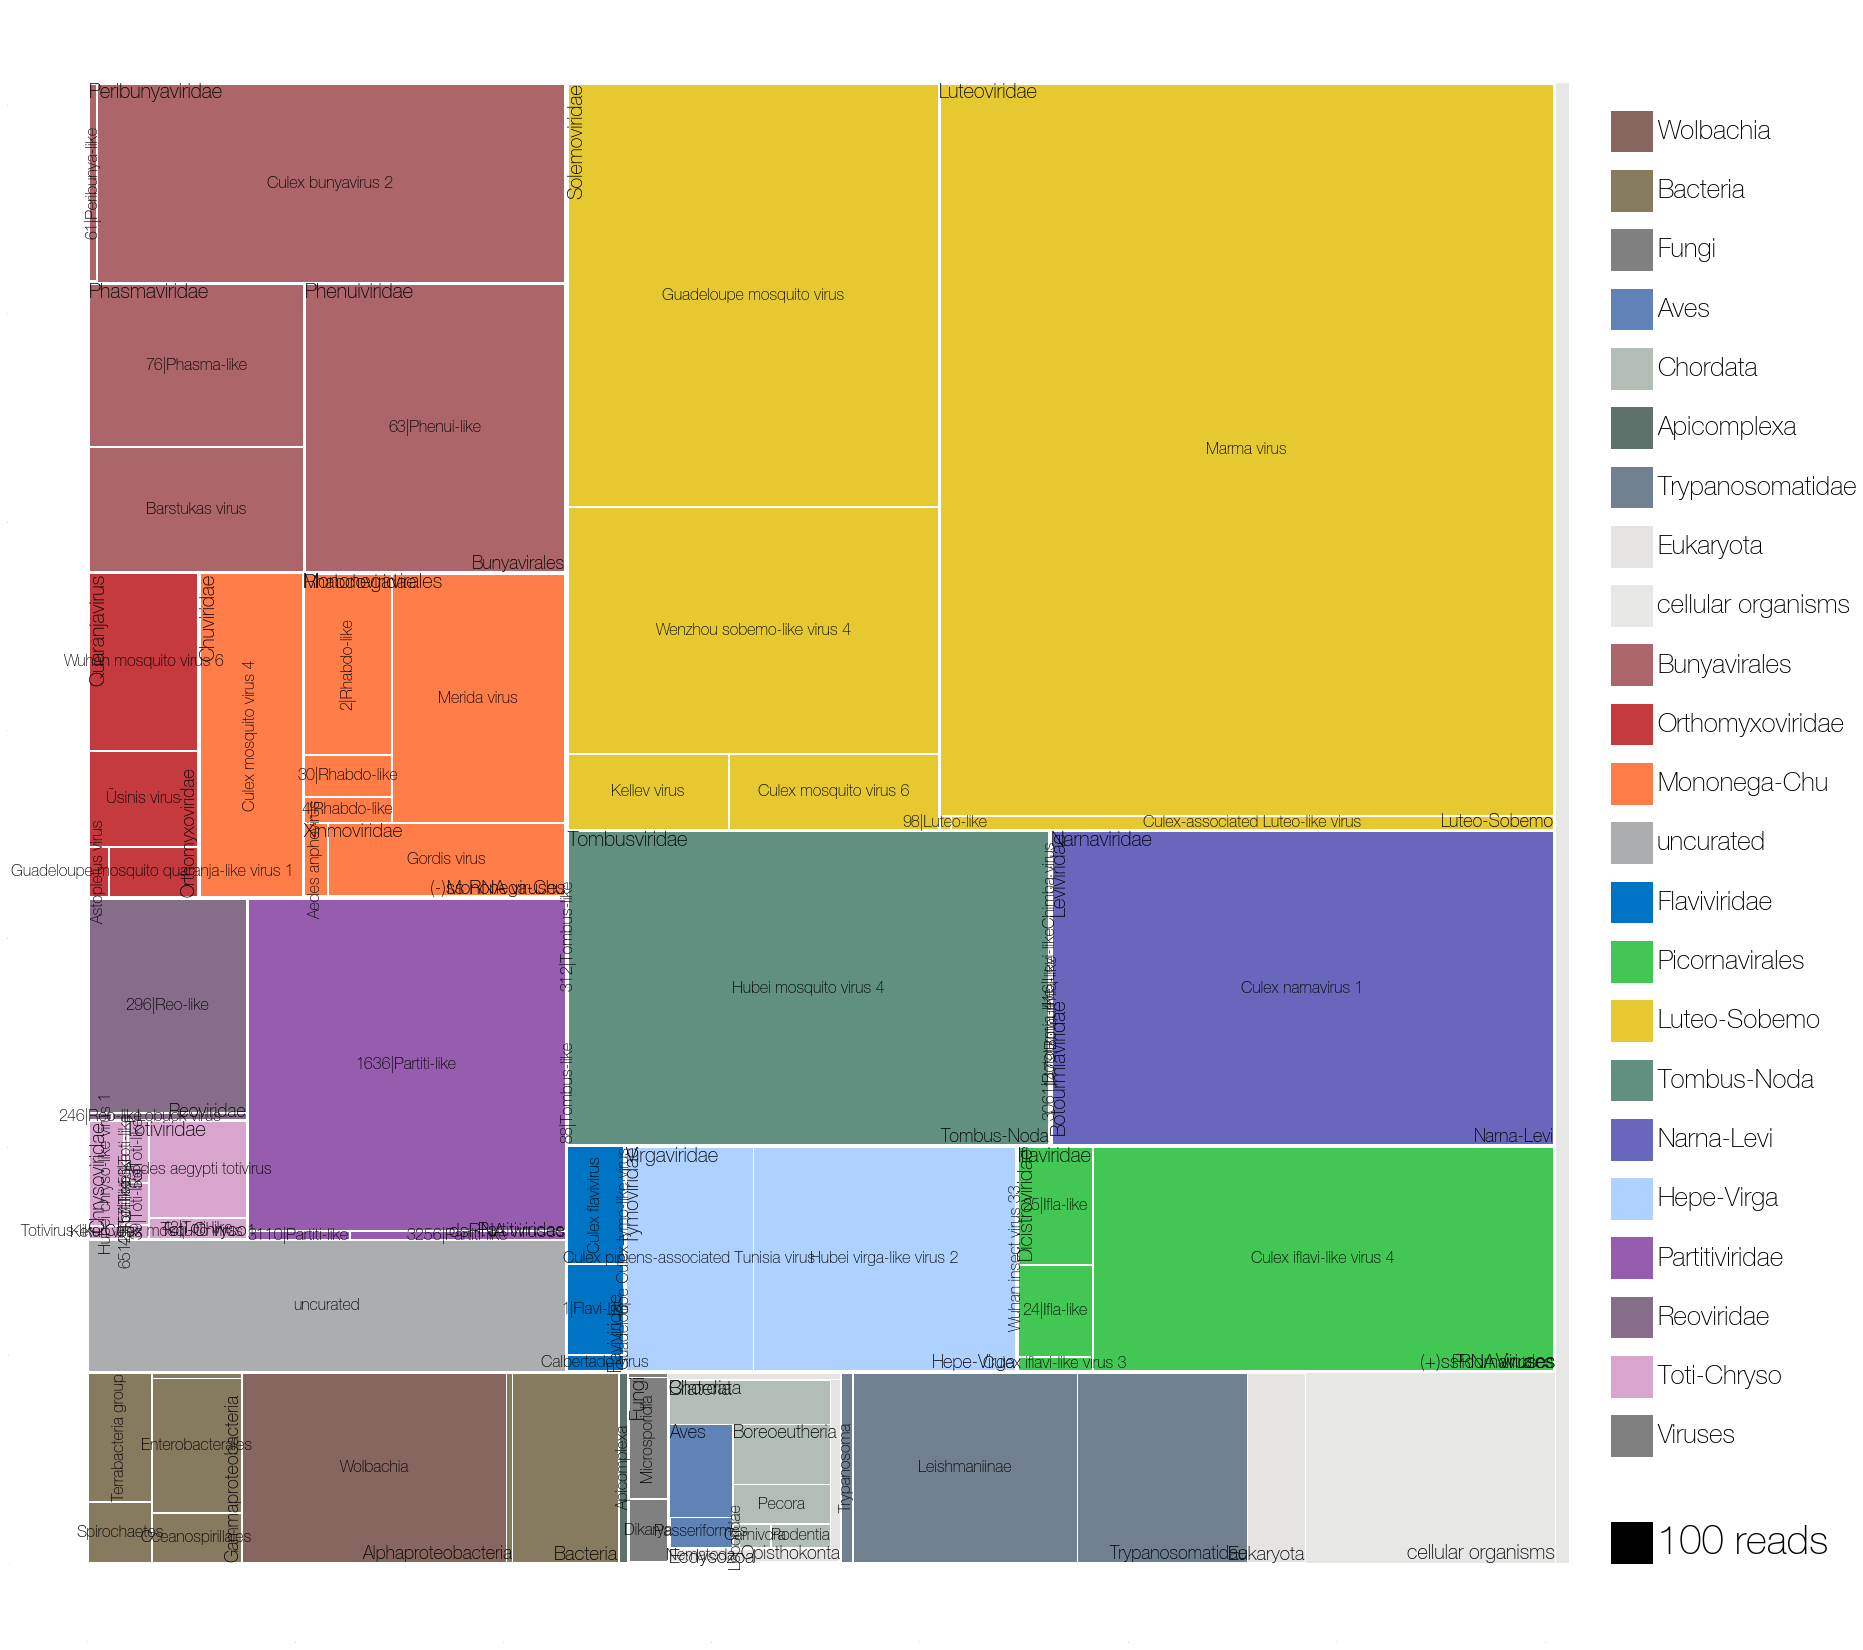

In [2]:
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42 ## TrueType fonts for manageable export

size=lambda k: k['attrs']['read_count'] ## area will be read counts
# size=lambda k: k['attrs']['contig_count'] ## area will be number of contigs

edge_length=np.sqrt(size(J['children'][0])) ## assuming
print(edge_length)

def computeCoordinates(node,x,y,dx,dy):
    """
    Compute treemap compartment coordinates using the squarify library.
    """
    node['attrs']['x']=x ## assign coordinates to compartment
    node['attrs']['y']=y
    node['attrs']['dx']=dx
    node['attrs']['dy']=dy
        
    if 'children' in node: ## there are children, need to traverse further
        children=sorted(node['children'],key=lambda q: size(q)) ## get children sorted by read count
        children_values=[size(child) for child in children] ## get read counts for each child
        sizes=squarify.normalize_sizes(children_values+[size(node)-sum(children_values)],dx,dy) ## normalize children values
        
        rects=squarify.padded_squarify(sizes,x,y,dx,dy) ## compute rectangles (padded)
#         rects=squarify.squarify(sizes,x,y,dx,dy) ## compute rectangles (unpadded)
        for ch,rec in zip(children,rects): ## iterate over children
            x=rec['x']
            y=rec['y']
            dx=rec['dx']
            dy=rec['dy']
            
            computeCoordinates(ch,x,y,dx,dy) ## recurse

def plot(ax,node,parent,previous=None,level=None):
    """
    Plot treemap.
    """
    if previous==None:
        previous=0.0
    if level==None:
        level=0
    
    if 'x' in node['attrs']:
        x=node['attrs']['x']
        y=node['attrs']['y']
        w=node['attrs']['dx']
        h=node['attrs']['dy']
        
        if w==0 or h==0:
            print('box %s has zero width or height: %s %s'%(node['taxonomy'],w,h))
        
        c=node['attrs']['colour']
#         lw=max([1,(7-level)])
        lw=1
        
        rect=plt.Rectangle((x,y),w,h,facecolor=c,edgecolor='w',
                           alpha=1.0,lw=lw,zorder=level) ## add rectangle
        
        rotation=0
        if h>(w*2):
            rotation=90 ## rotate labels if rectangle is taller than wider
        
        if 'taxonomy' in node and size(node)>100.0: ## only add names for compartments big enough
            name=node['taxonomy']
            if 'children' in node and name!='root':
                if level<5: ## when dealing with deep compartments plot label bottom right
                    ax.text(x+w-0.0015,y+0.0015,name,ha='right',va='bottom',
                        size=22-level,zorder=10000,rotation=rotation)
                else: ## otherwise top left
                    ax.text(x+0.0015,y+h-0.0015,name,ha='left',va='top',
                        size=25-level,zorder=level+10,rotation=rotation)

            elif 'children' not in node: ## terminal compartment, text is centered
                ax.text(x+w/2,y+h/2,name,ha='center',va='center',
                    size=16,zorder=level+10,rotation=rotation)

        ax.add_patch(rect)
        ax.plot()
    
    if 'children' in node:
        level+=1
        for child in node['children']:
            plot(ax,child,node,previous,level) ## recurse

fig = plt.figure(figsize=(30, 30),facecolor='w') 
gs = gridspec.GridSpec(1,1,wspace=0.01,hspace=0.01) 

ax=plt.subplot(gs[0],facecolor='w')

computeCoordinates(J,0.0,0.0,edge_length,edge_length) ## compute treemap coordinates, start at (0,0), width and height are edge_length (square treemap)
plot(ax,J,None) ## plot treemap

if edge_length>3000.0:
    unit=100.0 ## legend unit
    u='%d reads'%(int(unit)) ## legend label
    X=edge_length+100 ## x-axis offset
else:
    unit=4.0
    u='%d contigs'%(int(unit))
    X=-7

ax.text(X+unit*1.1,unit/2,u,size=40,va='center',ha='left') ## add text explaining what the legend square represents
    
print(unit,edge_length)

legend=plt.Rectangle((X,0.0),unit,unit,lw=2,facecolor='k',edgecolor='none',zorder=100,clip_on=False)
ax.add_patch(legend) ## add legend square

branchesByLevel=sorted(flatJ[2:], key=lambda k: (-k['attrs']['order'],k['attrs']['height']))
colours={}

for b in branchesByLevel:
    if b['attrs']['colour'] not in colours: ## plot legend squares until colours are exhausted (needs to be iterated over in the correct order)
        y=edge_length*0.1+len(colours)*edge_length/25.0 # y coordinate
        
        ax.add_patch(plt.Rectangle((X,y-unit),unit,unit,lw=2,facecolor=b['attrs']['colour'],edgecolor='none',zorder=1000,clip_on=False)) ## add legend rectangle
        
        ax.text(X+unit*1.1,y-unit/2.0,b['taxonomy'],size=26,ha='left',va='center') ## add name for compartment
        colours[b['attrs']['colour']]=b['taxonomy'] ## remember colour

[ax.spines[loc].set_visible(False) for loc in ax.spines]
ax.tick_params(size=0,labelsize=0)
ax.set_aspect(1)

plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig2_treemap.pdf',dpi=300,bbox_inches='tight')
plt.savefig('/Users/evogytis/Documents/manuscripts/skeeters/figures/fig2_treemap.png',dpi=300,bbox_inches='tight')
plt.show()

## Display read counts for treemap compartments split by sample

This cell will collect specified compartments of the treemap and display all the reads under the compartment split by sample, excluding nested compartments included in the plot.

Spirochaetes reads excluded from Bacteria
Terrabacteria group reads excluded from Bacteria
Gammaproteobacteria reads excluded from Bacteria
Alphaproteobacteria reads excluded from Bacteria


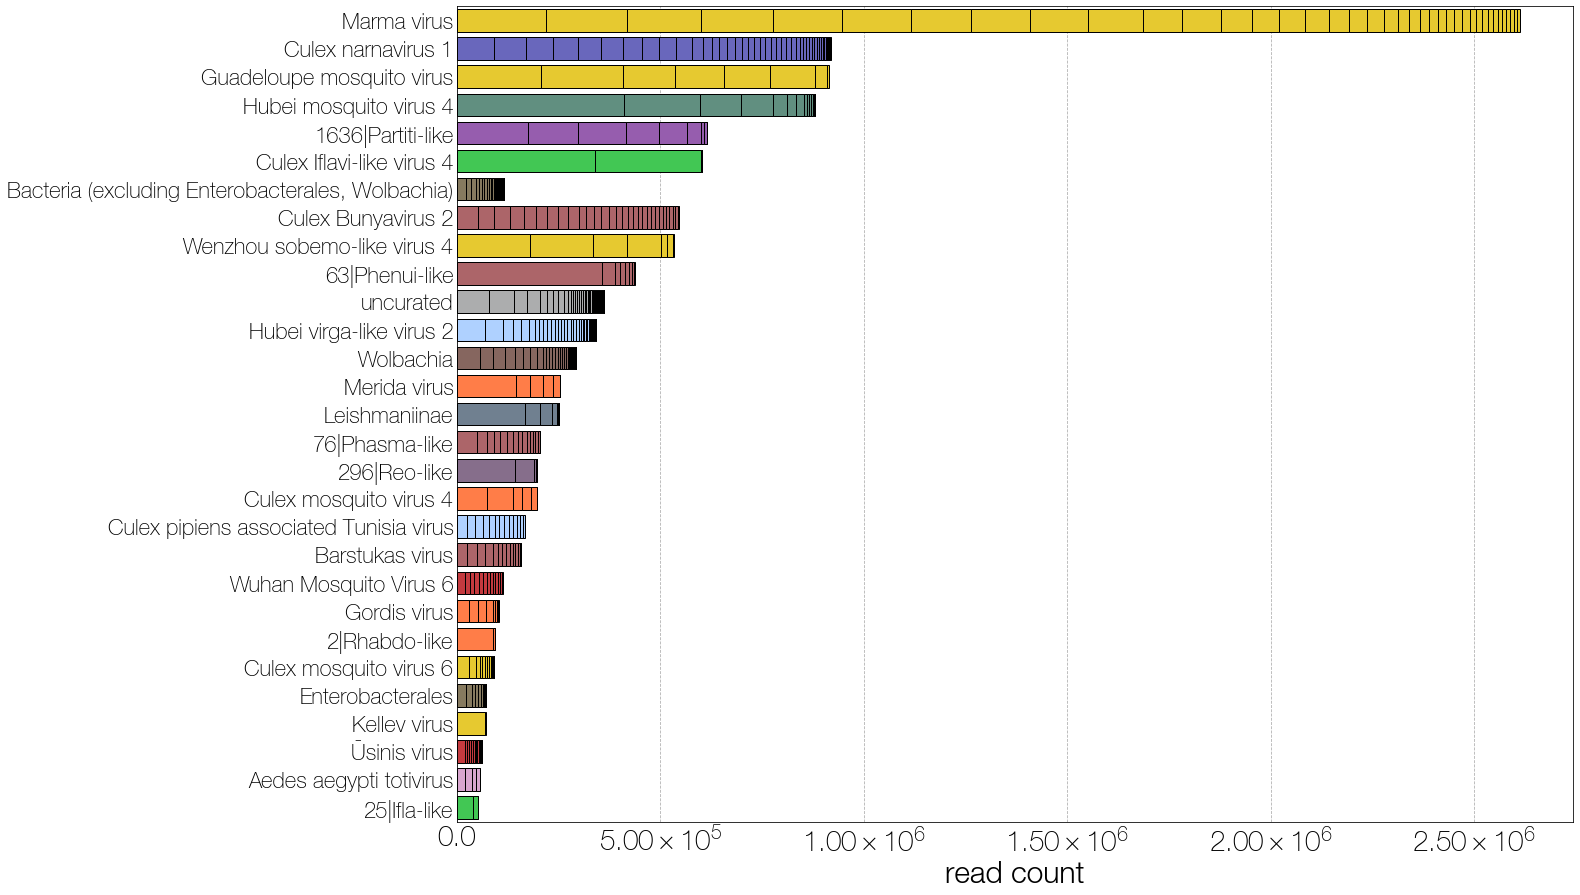

In [3]:
def split_reads(node,container=None,exclude=None):
    """
    Traverse subtree from a node, accumulating sample-specific read counts.
    """
    if container==None:
        container={}
    if exclude==None:
        exclude=lambda node: True
        
    for sample in [attr for attr in node['attrs'] if 'CMS' in attr]:
        if sample not in container:
            container[sample]=0
        container[sample]+=node['attrs'][sample]['read_count'] ## add reads to sample
        
    if 'children' in node: ## need to recurse
        for child in node['children']: ## iterate over children
            if exclude(child)==True: ## child not excluded
                split_reads(child,container,exclude=exclude) ## recurse
            else:
                print('%s reads excluded from %s'%(child['taxonomy'],node['taxonomy']))
    
    return container

fig = plt.figure(figsize=(20, 15),facecolor='w') 
gs = gridspec.GridSpec(1,1,wspace=0.01,hspace=0.01) 

ax=plt.subplot(gs[0],facecolor='w')

ylabels=[]
read_counts=[]
colours=[]

picked=[b for b in flatJ[1:] if b['attrs']['read_count']>5e4 and ('children' not in b or b['taxonomy']=='Bacteria')] ## programmatically get things that have high reads, are terminal (except if it's Bacteria)

include=[b['taxid'] for b in picked] ## list of taxids from branches

for k in sorted(picked,key=lambda w: w['attrs']['read_count']): ## iterate over picked branches, sorted by read count
    taxid_reads_per_sample=split_reads(k,exclude=lambda x: x in k['lineage'] and x not in include) ## do traversals accumulating reads (excluding other picked branches)
    read_counts.append(list(filter(lambda w:w!=0,sorted(taxid_reads_per_sample.values(),reverse=True)))) ## convert dict to list, sort by read count

    cur_clade=set(k['lineage'])
    include_clades={b['taxid']: set(b['lineage']) for b in flatJ[1:] if b['taxid'] in include}
    
    taxid_label=[]
    for t in include_clades: ## iterate over all other treemap compartments designated for display here
        if cur_clade.issubset(include_clades[t]): ## if another compartment's lienage is a subset of current one's (it's nested within current one)
            if isinstance(t,str):
                taxid_label.append(t)
            elif isinstance(t,int):
                taxid_label.append(ncbi.get_taxid_translator([t])[t]) ## continue adding to taxid label, first element is what's being displayed, every other element will be a compartment that's excluded

    if len(taxid_label)==1:
        ylabels.append(taxid_label[0])
    else:
        ylabels.append('%s (excluding %s)'%(taxid_label[0],', '.join(taxid_label[1:]))) ## format label

    colours.append(k['attrs']['colour']) ## remember colour

for i in range(len(ylabels)): ## iterate over compartments
    for j in range(len(read_counts[i])): ## iterate over sample-specific reads
        x=read_counts[i][j] ## current sample's read counts
        sx=sum(read_counts[i][:j]) ## sum of all other samples up to current one
        ax.barh(i,x,left=sx,fc=colours[i],ec='k',lw=1,alpha=1.0,align='center',zorder=10) ## plot stack
        
ax.set_yticks(range(len(ylabels)))
ax.set_yticklabels(ylabels)
ax.set_ylim(-0.5,len(ylabels)-0.5)

ax.set_xlabel('read count',size=30)

customfmt=lambda y,pos: r'$%.2f\times10^{%d}$'%(y*(10**-int(np.log10(y))),int(np.log10(y))) if y!=0.0 else '0.0'

ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(customfmt)) ## custom log formatted tick labels
ax.tick_params(size=0,labelsize=22)
ax.tick_params(axis='x',labelsize=28)

ax.grid(axis='x',ls='--',zorder=0)
plt.show()
